---
# Import libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

---
# Load GPU

In [4]:
!nvidia-smi

Tue Apr 15 06:46:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

---
# Test Convolutional layer and Max Pooling layer

In [6]:
def convolution_layer_test(filters, kernel_size, s=1, p='valid', input_size=[1, 64, 64, 3]):
    inputs = tf.random.normal(input_size) # sampling from normal distribution
    print('input size: ', inputs.shape)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, strides=s, padding=p)
    outputs = conv(inputs)
    print('output size: ', outputs.shape)

In [7]:
def pooling_layer_test(pool_size, s=1, p='valid', input_size=[1, 64, 64, 3]):
    inputs = tf.random.normal(input_size) # sampling from normal distribution
    print('input size: ', inputs.shape)
    pool = tf.keras.layers.MaxPool2D(pool_size, strides=s, padding=p)
    outputs = pool(inputs)
    print('output size: ', outputs.shape)

In [8]:
convolution_layer_test(10, 11, s=6, p='same', input_size=[1, 128, 128, 3])
# ceil(128/6) = 22가 되도록 zero padding

input size:  (1, 128, 128, 3)
output size:  (1, 22, 22, 10)


In [9]:
convolution_layer_test(10, 3)
# (64 - 3)/1 + 1 = 62

input size:  (1, 64, 64, 3)
output size:  (1, 62, 62, 10)


In [10]:
convolution_layer_test(100, 3)

input size:  (1, 64, 64, 3)
output size:  (1, 62, 62, 100)


In [11]:
convolution_layer_test(100, 3, p='same')

input size:  (1, 64, 64, 3)
output size:  (1, 64, 64, 100)


In [12]:
convolution_layer_test(100, 3, s=3, p='same')

input size:  (1, 64, 64, 3)
output size:  (1, 22, 22, 100)


In [13]:
pooling_layer_test(2)
# (64 - 2) / 1 +

input size:  (1, 64, 64, 3)
output size:  (1, 63, 63, 3)


In [14]:
pooling_layer_test(2, p='same')

input size:  (1, 64, 64, 3)
output size:  (1, 64, 64, 3)


---
# CNN for MNIST

In [15]:
(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(type(x_trainval), x_trainval.shape)
print(type(y_trainval), y_trainval.shape)

x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size= 1/6, shuffle=True, stratify = y_trainval, random_state=34)
print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'numpy.ndarray'> (60000, 28, 28)
<class 'numpy.ndarray'> (60000,)
<class 'numpy.ndarray'> (50000, 28, 28)
<class 'numpy.ndarray'> (50000,)


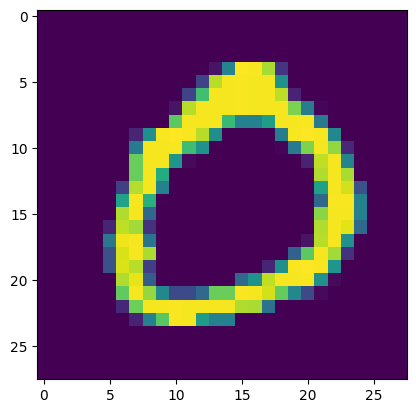

In [16]:
plt.imshow(x_train[0])

In [17]:
# Scale to [0, 1]
x_train, x_valid, x_test = x_train.astype('float32') / 255 , x_valid.astype('float32') / 255, x_test.astype('float32') / 255

# CNN need a dimension of channels
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(50000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)
(50000,) (10000,) (10000,)


## Use a Sequential class

In [18]:
cnn = Sequential()

cnn.add(layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', input_shape=(28,28,1)))
cnn.add(layers.MaxPool2D(3, strides=2, padding='same'))
cnn.add(layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'))
cnn.add(layers.MaxPool2D(3, strides=2, padding='same'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cnn.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate=0.1), metrics = ['accuracy'])

In [20]:
result = cnn.fit(x_train, y_train, epochs = 5, batch_size = 128, validation_data = (x_valid, y_valid))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7066 - loss: 0.8952 - val_accuracy: 0.9516 - val_loss: 0.1492
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9703 - loss: 0.0949 - val_accuracy: 0.9727 - val_loss: 0.0843
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9801 - loss: 0.0640 - val_accuracy: 0.9824 - val_loss: 0.0558
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9845 - loss: 0.0495 - val_accuracy: 0.9814 - val_loss: 0.0569
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9869 - loss: 0.0394 - val_accuracy: 0.9823 - val_loss: 0.0539


In [21]:
test_result = cnn.evaluate(x_test, y_test)
print('test loss: ', test_result[0])
print('test acc: ', test_result[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9821 - loss: 0.0517
test loss:  0.042001258581876755
test acc:  0.98580002784729


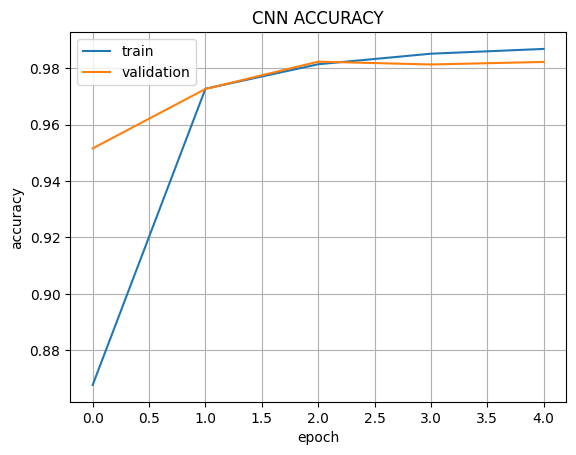

In [22]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('CNN ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['train','validation'], loc = 'best')

---
# A function for implementing training easily

In [23]:
data = [x_train, y_train, x_valid, y_valid, x_test, y_test]

def train(model, x_train, y_train, x_valid, y_valid, x_test, y_test, epoch = 10, lr = 0.1):
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate=lr), metrics = ['accuracy'])
    result = model.fit(x_train, y_train, epochs = epoch, batch_size = 128, validation_data = (x_valid, y_valid))
    test_result = cnn.evaluate(x_test, y_test)

    # show the learning curve
    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('CNN ACCURACY')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['train','validation'], loc = 'best')

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9893 - loss: 0.0336 - val_accuracy: 0.9833 - val_loss: 0.0513
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9902 - loss: 0.0293 - val_accuracy: 0.9848 - val_loss: 0.0480
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9923 - loss: 0.0260 - val_accuracy: 0.9891 - val_loss: 0.0370
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9871 - loss: 0.0356


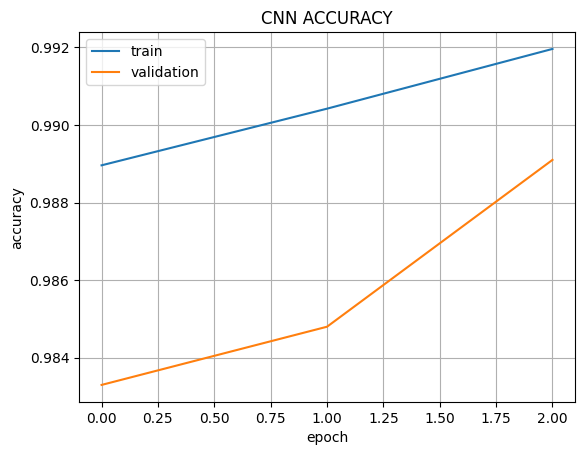

In [24]:
train(cnn, *data, epoch=3)

## Use a Model class

In [25]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', input_shape=(28,28,1))
        self.maxpool1 = layers.MaxPool2D(3, strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, strides=1, padding='same', activation='relu')
        self.maxpool2 = layers.MaxPool2D(3, strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(10, activation='softmax')


    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7068 - loss: 0.9130 - val_accuracy: 0.9514 - val_loss: 0.1723
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9700 - loss: 0.0975 - val_accuracy: 0.9804 - val_loss: 0.0650
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9797 - loss: 0.0629 - val_accuracy: 0.9843 - val_loss: 0.0538
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9841 - loss: 0.0490 - val_accuracy: 0.9837 - val_loss: 0.0569
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9865 - loss: 0.0415 - val_accuracy: 0.9885 - val_loss: 0.0397
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9890 - loss: 0.0353 - val_accuracy: 0.9890 - val_loss: 0.0369
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9901 - loss: 0.0294 - val_accuracy: 0.9899 - val_loss: 0.0352
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9918 - loss: 0.0248 - val_accuracy: 0.

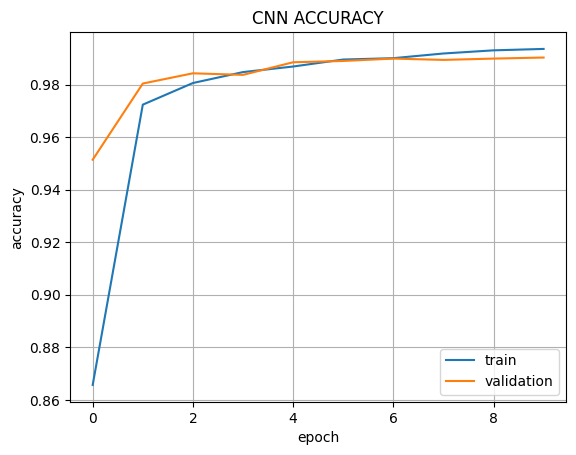

In [26]:
cnn = CNN()
train(cnn, *data)

---
# CIFAR-10

In [27]:
(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [28]:
print(type(x_trainval), x_trainval.shape)
print(type(y_trainval), y_trainval.shape)
print(type(x_test), x_test.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (50000, 32, 32, 3)
<class 'numpy.ndarray'> (50000, 1)
<class 'numpy.ndarray'> (10000, 32, 32, 3)
<class 'numpy.ndarray'> (10000, 1)


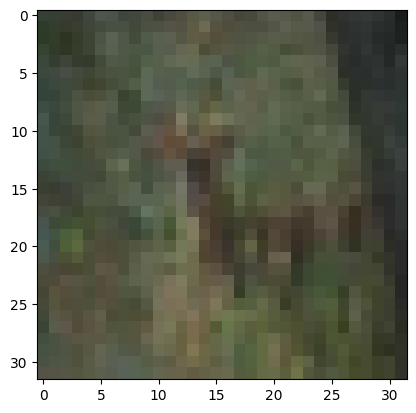

In [29]:
plt.imshow(x_trainval[10])

In [30]:
# Normalize to range 0 - 1
x_trainval = x_trainval.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Split train and validation dataset
x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size= 1/6, shuffle=True, stratify = y_trainval, random_state=34)

In [31]:
print(type(x_train), x_trainval.shape)
print(type(y_train), y_train.shape)
print(type(x_valid), x_valid.shape)
print(type(y_valid), y_valid.shape)
print(type(x_test), x_test.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (50000, 32, 32, 3)
<class 'numpy.ndarray'> (41666, 1)
<class 'numpy.ndarray'> (8334, 32, 32, 3)
<class 'numpy.ndarray'> (8334, 1)
<class 'numpy.ndarray'> (10000, 32, 32, 3)
<class 'numpy.ndarray'> (10000, 1)


In [32]:
#############
# Important #
#############

data = [x_train, y_train, x_valid, y_valid, x_test, y_test]

---
# CNN

In [33]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3))
        self.maxpool1 = layers.MaxPool2D(3, strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, strides=1, padding='same', activation='relu')
        self.maxpool2 = layers.MaxPool2D(3, strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(10, activation='softmax')


    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2283 - loss: 2.1150 - val_accuracy: 0.3564 - val_loss: 1.8200
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4609 - loss: 1.5095 - val_accuracy: 0.4508 - val_loss: 1.6016
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5535 - loss: 1.2686 - val_accuracy: 0.5774 - val_loss: 1.1899
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6082 - loss: 1.1125 - val_accuracy: 0.5683 - val_loss: 1.2065
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6440 - loss: 1.0096 - val_accuracy: 0.6230 - val_loss: 1.0936
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6852 - loss: 0.9060 - val_accuracy: 0.6685 - val_loss: 0.9582
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7068 - loss: 0.8375 - val_accuracy: 0.6599 - val_loss: 0.9837
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7366 - loss: 0.7515 - val_accuracy: 0

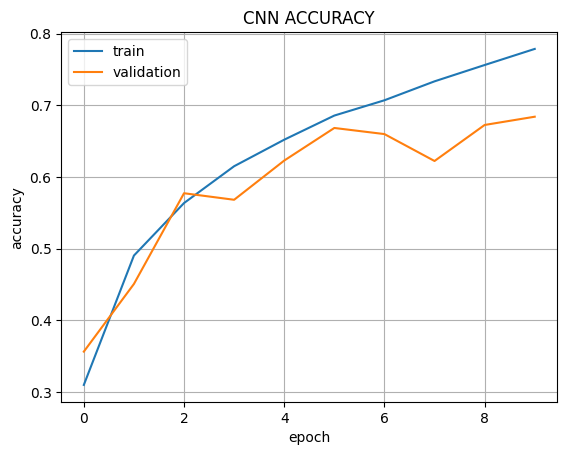

In [34]:
cnn = CNN()
train(cnn, *data)

---
# Let's upgrade the network

## Use more layers

In [35]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', input_shape=(32,32,3))
        self.conv2 = layers.Conv2D(32, 3, strides=1, padding='same', activation='relu')
        self.maxpool1 = layers.MaxPool2D(3, strides=2, padding='same')
        self.conv3 = layers.Conv2D(64, 3, strides=1, padding='same', activation='relu')
        self.conv4 = layers.Conv2D(64, 3, strides=1, padding='same', activation='relu')
        self.maxpool2 = layers.MaxPool2D(3, strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(10, activation='softmax')
        self.relu = layers.ReLU()


    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1709 - loss: 2.2279 - val_accuracy: 0.2583 - val_loss: 2.2336
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3989 - loss: 1.6970 - val_accuracy: 0.5062 - val_loss: 1.3624
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5223 - loss: 1.3407 - val_accuracy: 0.5666 - val_loss: 1.2419
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6005 - loss: 1.1260 - val_accuracy: 0.5558 - val_loss: 1.2479
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6474 - loss: 1.0104 - val_accuracy: 0.5860 - val_loss: 1.2001
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7067 - loss: 0.8411 - val_accuracy: 0.6908 - val_loss: 0.8952
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7421 - loss: 0.7330 - val_accuracy: 0.6836 - val_loss: 0.9260
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7796 - loss: 0.6358 - val_accura

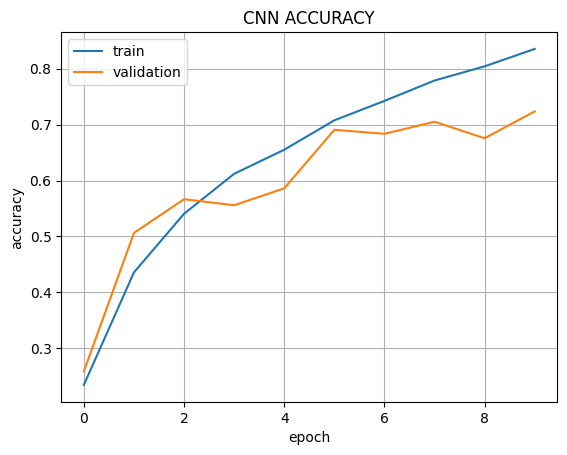

In [36]:
cnn = CNN()
train(cnn, *data)

## Use batch normalization

In [37]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, strides=1, padding='same', input_shape=(32,32,3))
        self.bn1 = layers.BatchNormalization()
        self.maxpool1 = layers.MaxPool2D(3, strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.maxpool2 = layers.MaxPool2D(3, strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(10, activation='softmax')
        self.relu = layers.ReLU()


    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2241 - loss: 2.1195 - val_accuracy: 0.4402 - val_loss: 1.6186
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4598 - loss: 1.5211 - val_accuracy: 0.4411 - val_loss: 1.5598
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5438 - loss: 1.2787 - val_accuracy: 0.5001 - val_loss: 1.4133
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6017 - loss: 1.1337 - val_accuracy: 0.6174 - val_loss: 1.0800
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6440 - loss: 1.0170 - val_accuracy: 0.5754 - val_loss: 1.1913
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6784 - loss: 0.9207 - val_accuracy: 0.6614 - val_loss: 0.9574
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7027 - loss: 0.8456 - val_accuracy: 0.6603 - val_loss: 0.9816
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7374 - loss: 0.7596 - val_accuracy: 0

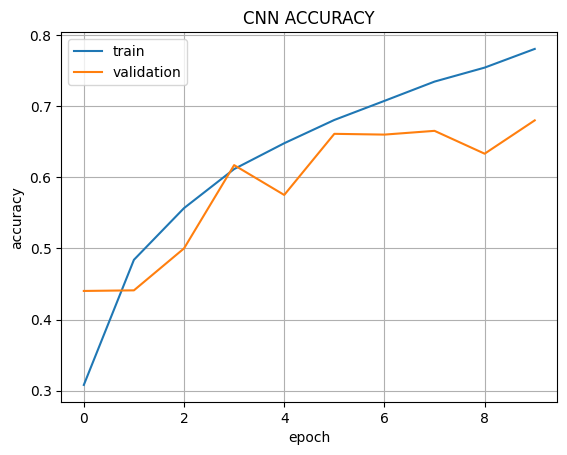

In [38]:
cnn = CNN()
train(cnn, *data)

---
# Make Network more easily - use a function

In [39]:
def make_conv_block(num_filters, filter_size, stride, padding='same', input_shape=None):
    conv_block = tf.keras.Sequential()
    if input_shape is not None:
        conv_block.add(layers.Conv2D(num_filters, filter_size, strides=stride, padding=padding, input_shape=input_shape))
    conv_block.add(layers.Conv2D(num_filters, filter_size, strides=stride, padding=padding))
    conv_block.add(layers.BatchNormalization())
    conv_block.add(layers.ReLU())
    return conv_block

In [40]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = make_conv_block(32, 3, 1, 'same', (32, 32, 3))
        self.conv2 = make_conv_block(32, 3, 1, 'same')
        self.maxpool1 = layers.MaxPool2D(3, strides=2, padding='same')

        self.conv3 = make_conv_block(64, 3, 1, 'same')
        self.conv4 = make_conv_block(64, 3, 1, 'same')
        self.maxpool2 = layers.MaxPool2D(3, strides=2, padding='same')

        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(10, activation='softmax')
        self.relu = layers.ReLU()


    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1490 - loss: 2.2696 - val_accuracy: 0.2496 - val_loss: 2.0622
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3362 - loss: 1.8551 - val_accuracy: 0.4551 - val_loss: 1.5062
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4887 - loss: 1.4218 - val_accuracy: 0.5564 - val_loss: 1.2454
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5649 - loss: 1.2096 - val_accuracy: 0.5169 - val_loss: 1.3755
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6176 - loss: 1.0708 - val_accuracy: 0.6421 - val_loss: 1.0158
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6760 - loss: 0.9174 - val_accuracy: 0.6157 - val_loss: 1.1400
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7170 - loss: 0.8021 - val_accuracy: 0.6969 - val_loss: 0.8988
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7523 - loss: 0.6954 - val_acc

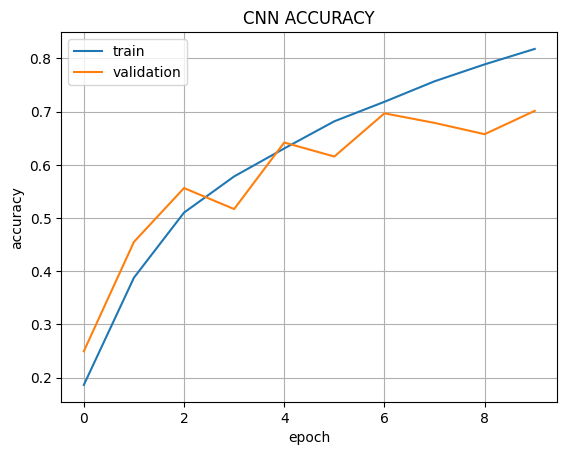

In [41]:
cnn = CNN()
train(cnn, *data)

---
# Make Network more easily - use a custom layer

In [42]:
class ConvBlock(layers.Layer):
    def __init__(self, num_filters, filter_size, stride, padding='same', input_shape=None):
        super(ConvBlock, self).__init__()
        if input_shape is not None:
            self.conv = layers.Conv2D(num_filters, filter_size, strides=stride, padding=padding, input_shape=input_shape)
        else:
            self.conv = layers.Conv2D(num_filters, filter_size, strides=stride, padding=padding)
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [43]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = ConvBlock(32, 3, 1, 'same', (32, 32, 3))
        self.conv2 = ConvBlock(32, 3, 1, 'same')
        self.maxpool1 = layers.MaxPool2D(3, strides=2, padding='same')

        self.conv3 = ConvBlock(64, 3, 1, 'same')
        self.conv4 = ConvBlock(64, 3, 1, 'same')
        self.maxpool2 = layers.MaxPool2D(3, strides=2, padding='same')

        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(10, activation='softmax')
        self.relu = layers.ReLU()


    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1571 - loss: 2.2477 - val_accuracy: 0.2835 - val_loss: 1.9255
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3792 - loss: 1.7441 - val_accuracy: 0.4976 - val_loss: 1.3932
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5097 - loss: 1.3734 - val_accuracy: 0.5221 - val_loss: 1.3285
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5851 - loss: 1.1847 - val_accuracy: 0.5360 - val_loss: 1.3143
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6455 - loss: 1.0043 - val_accuracy: 0.6262 - val_loss: 1.0750
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6845 - loss: 0.9016 - val_accuracy: 0.6182 - val_loss: 1.0875
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7194 - loss: 0.8036 - val_accuracy: 0.6848 - val_loss: 0.9106
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7627 - loss: 0.6717 - val_accu

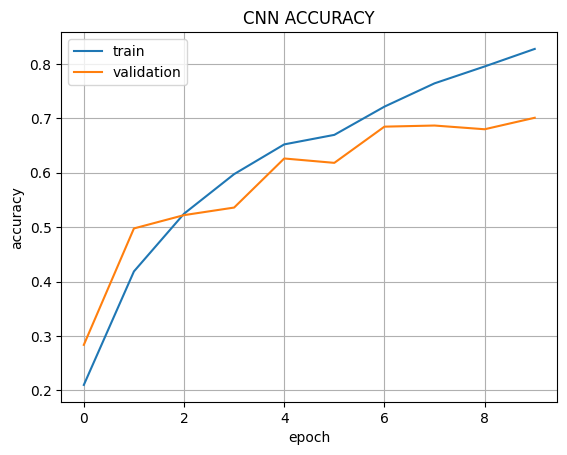

In [44]:
cnn = CNN()
train(cnn, *data)